<a href="https://colab.research.google.com/github/danielzt12/AD_LTEM/blob/main/AD_LTEM_sim_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [2]:
!git clone https://github.com/danielzt12/AD_LTEM

fatal: destination path 'AD_LTEM' already exists and is not an empty directory.


In [75]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import signal as tfs
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import sys, time
from scipy.fftpack import *
from skimage.restoration import unwrap_phase, denoise_tv_chambolle
from scipy import ndimage
from google.colab import output
import tifffile as tif
import gdown

sys.path.append("AD_LTEM")

from torch.cuda import get_device_name
print("GPU:", get_device_name(0))

GPU: Tesla T4


In [78]:
# truth for amplitude and phase

true_amplitude =  tif.imread('AD_LTEM/design_amp.tiff')
true_phase = tif.imread('AD_LTEM/design_tphi.tiff')
true_phase -= true_phase.mean()

In [65]:
# load pre-generated data set, the stored values are the square root of the intensities already
noise = 10
# there are 65 defocus images equally distributed between -1.6 mm and 1.6 mm
defocus = np.linspace(-1.6e6,1.6e6,65)

if noise == 0:
  !gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
  A_samples = np.load("amplitude4TIE_noise0.npy")
elif noise == 5:
  !gdown "http://drive.google.com/uc?id=11X3ZvbEF3tuKV1hmYL_lDJIi1YShgms4"
  A_samples = np.load("amplitude4TIE_noise5.npy")
elif noise == 10:
  !gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
  A_samples = np.load("amplitude4TIE_noise10.npy")
elif noise == 14:
  !gdown "http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf"
  A_samples = np.load("amplitude4TIE_noise14.npy")
elif noise == 15:
  !gdown "http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l"
  A_samples = np.load("amplitude4TIE_noise15.npy")
elif noise == 20:
  !gdown "http://drive.google.com/uc?id=10tD8eOdh9MmTl5SpoetrMbWhN7lFz_iv"
  A_samples = np.load("amplitude4TIE_noise20.npy")
elif noise == 30:
  !gdown "http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca"
  A_samples = np.load("amplitude4TIE_noise30.npy")
elif noise == 40:
  !gdown "http://drive.google.com/uc?id=15yC64QAoWNDd6bSDd7_7lCa-Ic4ztgxA"
  A_samples = np.load("amplitude4TIE_noise40.npy")

print("estimated noise from transparent region : {0:.1f}%".format(A_samples[:,280:320,280:320].std()*200))

Downloading...
From: http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk
To: /content/amplitude4TIE_noise10.npy
136MB [00:00, 151MB/s]
estimated noise from flat region : 11.8%


Text(0.5, 1.0, '1600000.0 nm')

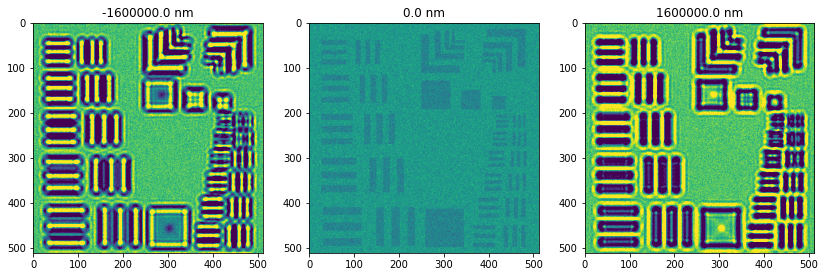

In [66]:
f, ax = plt.subplots(ncols=3, figsize = (14,8))
ax[0].imshow(A_samples[0], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[0].set_title("{0} nm".format(defocus[0]))
ax[1].imshow(A_samples[32], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[1].set_title("{0} nm".format(defocus[32]))
ax[2].imshow(A_samples[64], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[2].set_title("{0} nm".format(defocus[64]))

In [68]:
# generate microscopic transfer function

from microscopes_fwd import Microscope

defocus = np.linspace(-1.6e6,1.6e6,65)

#inititiate microscope class
TEM = Microscope(Cs = 1.0e6, theta_c = 0.01e-3, def_spr = 500)

#reciprocal space vectors
[dim,dim] = ampli_sample.shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

# define pixel resolution in nm.
del_px = 5 #nm/px

tf_microscope = np.zeros(A_samples.shape, dtype=np.complex64)
for i in range(defocus.shape[0]):
  TEM.defocus = defocus[i]
  tf_microscope[i] = TEM.getTransferFunction(qq, del_px)
  #A_samples[i] = np.abs((ifft2(tf_microscope[i]*fftshift(fft2(true_amplitude*np.exp(1j*true_phase))))))

#A_samples /= A_samples.mean(1).mean(1)[:,np.newaxis,np.newaxis]

In [74]:
selection = [28,30,62,64]
print("chosen defocus (mm): ", defocus[selection]/1e6)

TF = tf_microscope[selection]
exp_data = A_samples[selection]

chosen defocus (mm):  [-0.2 -0.1  1.5  1.6]


# Phase Retrieval

In [103]:
# the loss function

def compute_loss():

  global gerr 

  tf_obj_real = guess_amplitude*tf.math.cos(guess_phase)
  tf_obj_imag = guess_amplitude*tf.math.sin(guess_phase)
  tf_obj = tf.complex(tf_obj_real, tf_obj_imag)

  cal_data = tfs.ifft2d(tfs.ifftshift(tfs.fftshift(tfs.fft2d(tf_obj))*TF, axes=(1,2)))

  cal_data = tf.abs(cal_data)
  cal_data /= tf.reduce_mean(cal_data, axis=(1,2), keepdims=True)

  losses = tf.reduce_mean((cal_data - exp_data)**2)

  gerr = losses
  return losses


In [104]:
# ADAM gradient descent optimization

def optimize(tol=1e-9, max_iter=10000, lr=1):
  err = np.Inf # step error (banach), not actual erro
  i = 0
  errs = []
  accs = []

  for i in (range(max_iter)):
    opt = tf.optimizers.Adam(learning_rate=lr)
    train = opt.minimize(compute_loss, var_list=[guess_phase]) #Optim only over phase
    result_phase = guess_phase.numpy()
    result_phase = unwrap_phase(result_phase)
    result_phase -= result_phase.mean()
    acc = (result_phase*true_phase).sum() / np.sqrt((result_phase*result_phase).sum() * (true_phase*true_phase).sum())
    accs.append(acc)
    errs.append(gerr.numpy())
    if i>10:
      if np.abs(errs[-1]-errs[-2]) < tol:
        break
    i += 1

  return result_phase, np.array(errs), np.array(accs), i

In [105]:
# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = tf.constant(denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False), dtype='float32')
# initialize the phase as 0.5 everywhere
guess_phase = tf.Variable(np.zeros(A_samples[32].shape)+0.5, dtype='float32') 

In [111]:
tot_errs = []
tot_accs = []

lr = .8
max_iter = 10000
t1=time.time()
result=optimize(1e-10,max_iter=max_iter,lr=lr)
t2=time.time()
print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,result[3]))
print("final err {0}".format(result[1][-1]))
print("final acc {0:.3f} ".format(result[2][-1]))
print("max acc {0:.3f} at iteration #{1:d}: ".format(result[2].max(), result[2].argmax()))

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

total elapsed time 26.2 s for 1511 iterations: 
final err 0.00202709948644042
final acc 0.975 
max acc 0.975 at 1511: 


Text(0.5, 1.0, 'acc')

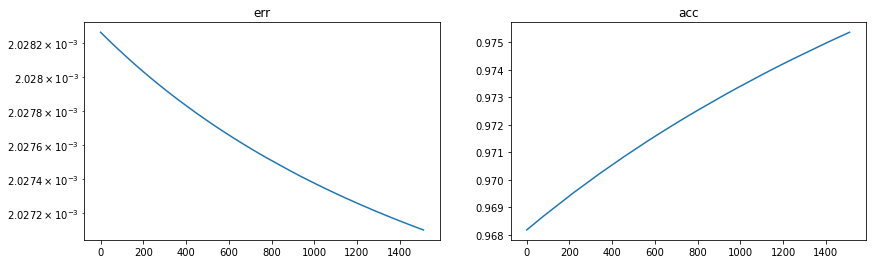

In [112]:
f, ax = plt.subplots(ncols=2, figsize = (14,4))
ax[0].semilogy(result[1])
ax[0].set_title("err")
ax[1].plot(result[2])
ax[1].set_title("acc")

Text(0.5, 1.0, 'result')

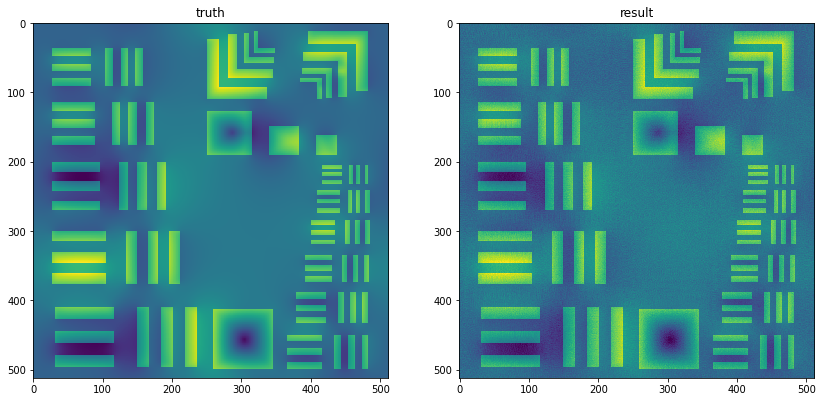

In [113]:
# show phase
f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(true_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[0].set_title("truth")
ax[1].imshow(result[0], interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[1].set_title("result")

Text(0.5, 1.0, 'result')

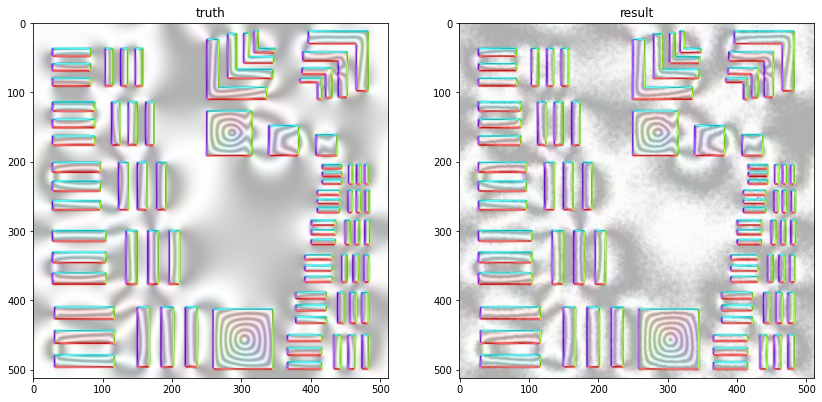

In [121]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = plt.subplots(ncols=2, figsize = (14,8))

t1 = np.copy(true_phase)
t1=ndimage.gaussian_filter(t1-np.mean(t1),1,order=0)
gx=np.gradient(t1,axis=0)
gy=np.gradient(t1,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[0].imshow(rgb_map)
ax[0].set_title("truth")
ax[0].imshow(np.cos(t1*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)

t2 = np.copy(result[0])
t2=ndimage.gaussian_filter(t2-np.mean(t2),1,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)
ax[1].set_title("result")